<a href="https://colab.research.google.com/github/alina-bogdanovskaya/Data-Analysis_May2022/blob/lesson2/Data_Analysis_lesson2_L2_penalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as sklearn_LR
from sklearn.linear_model import Ridge as sklearn_Ridge
from math import e
from sklearn.metrics import r2_score 


In [ ]:
class linear_regression:
  def __init__(self, eta = 0.9, max_iter = 1e4, min_weight_dist = 1e-8):
    self.eta = eta
    self.max_iter = max_iter
    self.min_weight_dist = min_weight_dist

  def _mserror(self, X, y_real):
    y = X.dot(self.w.T)+self.w0
    return np.sum((y - y_real)**2) / y_real.shape[0] 

  def _mserror_grad(self, X, y_real):
    delta=(X.dot(self.w.T)+self.w0-y_real) # delta = y - y_real
    return 2*delta.T.dot(X)/y_real.shape[0], 2*np.sum(delta)/y_real.shape[0]
    
  def _optimize(self, X, Y):
    iter_num = 0
    weight_dist = np.inf
    self.w = np.zeros((1, X.shape[1]))
    self.w0=0
    eta = self.eta
    while weight_dist > self.min_weight_dist and iter_num < self.max_iter:
      gr_w, gr_w0=self._mserror_grad(X, Y)
      if iter_num==0:
        eta=self.eta/np.sqrt(np.linalg.norm(gr_w)**2+(gr_w0)**2)
        
      new_w = self.w - eta * gr_w
      new_w0= self.w0 - eta * gr_w0
      weight_dist = np.sqrt(np.linalg.norm(new_w - self.w)**2+(new_w0 - self.w0)**2)
      iter_num += 1
      self.w = new_w
      self.w0 = new_w0
      self.iter_num = iter_num
              
  def fit(self, X, Y):
    if Y.ndim==1:
      Y=Y[:, np.newaxis]
        
    self._optimize(X, Y)
    return self
    
  def predict(self, X):
    return (X.dot(self.w.T)+self.w0).flatten()
    
  def test(self, X, Y):
    if Y.ndim==1:
      Y=Y[:, np.newaxis]
    
    return self._mserror(X, Y)

  def weights(self):
    return self.w, self.w0
    

class polynomial_regression(linear_regression):
  def __init__(self, max_power, *args, **kwargs):
    self.max_power=max_power
    super().__init__(*args, **kwargs)
    
  @staticmethod
  def generate_features(x, max_power):
    x=x[:, np.newaxis]
    return np.concatenate([x**i for i in range(1, max_power+1)], axis=1)
    
  def fit(self, x, y):
    super().fit(self.generate_features(x, self.max_power), y)
    
  def predict(self, x):
    return super().predict(self.generate_features(x, self.max_power))
    
  def test(self, x, y):
    return super().test(self.generate_features(x, self.max_power), y)

In [ ]:
class polynomial_regression_sklearn_ridge(sklearn_Ridge):
  def __init__(self, max_power, *args, **kwargs):
    self.max_power=max_power
    super().__init__(solver='lsqr', *args, **kwargs)
  
  generate_features=staticmethod(polynomial_regression.generate_features)
    
  def fit(self, x, y):
    super().fit(self.generate_features(x, self.max_power), y)
    
  def predict(self, x):
    return super().predict(self.generate_features(x, self.max_power))
    
  def test(self, x, y):
    return np.sum((self.predict(x) - y)**2) / y.shape[0]

In [ ]:
class polynomial_regression_lbfgs(polynomial_regression):
  def __init__(self, max_power):
    self.max_power=max_power
  
  def _optimize(self, X, Y):
    def assign_w(w):
      self.w0=w[0]
      self.w=w[1:][np.newaxis, :]
    
    def func(w):
      assign_w(w)
      return super(polynomial_regression, self).test(X, Y)
        
    def jac(w):
      assign_w(w)
      gr_w, gr_w0=self._mserror_grad(X, Y)
      return np.concatenate([[gr_w0], gr_w.flatten()])
        
    w=np.zeros((X.shape[1]+1,))
    w=minimize(func, w, jac=jac, method='BFGS').x
    assign_w(w)


class polynomial_regression_lbfgs_l2_reg(polynomial_regression_lbfgs):
  def __init__(self, l2_coeff, *args, **kwargs):
    self.l2_coeff = l2_coeff
    super().__init__(*args, **kwargs)

  def _mserror(self, X, y_real):
    y = X @ self.w.T + self.w0
    return (np.sum((y - y_real)**2) + np.sum(self.w**2)*self.l2_coeff) / y_real.shape[0]

  def _mserror_grad(self, X, y_real):
    delta = X @ self.w.T + self.w0 - y_real
    #print(2*np.sum(np.abs(self.w))*self.l2_coeff/ y_real.shape[0])
    return (2*delta.T @ X - 2*np.sum(self.w)*self.l2_coeff) / y_real.shape[0], 2*np.sum(delta) / y_real.shape[0] 

In [ ]:
def f(x):
  return 0.6 - 13.2 * x - 5.3 * x ** 2 - 4.17 * x ** 3

In [ ]:
x = np.linspace(-10, 10, 100)
np.random.seed(133)
x_data = np.random.uniform(-10, 10, size=(10,))
f_data = [f(i) for i in x_data] + np.random.uniform(-1000, 1000, size=(10,))

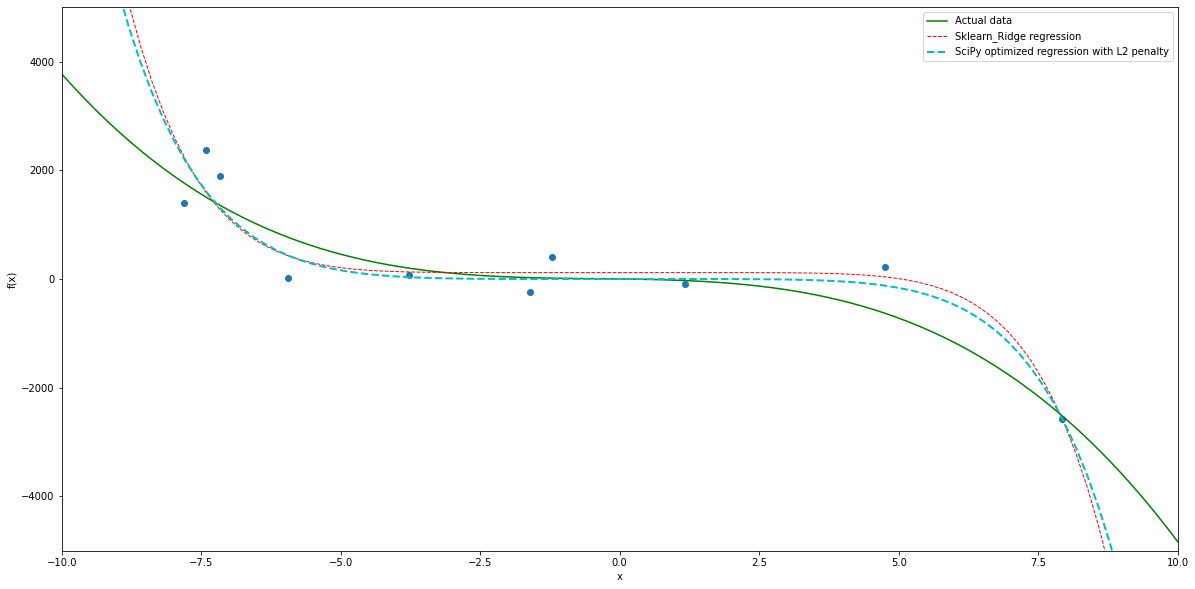

In [ ]:
#Актуальные данные
fig = plt.figure(figsize=(20,10))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(x, f(x), color='g', label='Actual data')
plt.scatter(x_data, f_data)

#Sklearn_Ridge
model_skr = polynomial_regression_sklearn_ridge(7, alpha=1)
model_skr.fit(x_data, f_data)
plt.plot(x, model_skr.predict(x), 'r--', linewidth=1, label='Sklearn_Ridge regression')

#Полиномиальная регрессия_SciPy с L2 регуляризацией 
model_l2 = polynomial_regression_lbfgs_l2_reg(10**7, 7)
model_l2.fit(x_data, f_data)
plt.plot(x, model_l2.predict(x), 'c--', linewidth=2, label='SciPy optimized regression with L2 penalty')

plt.legend()

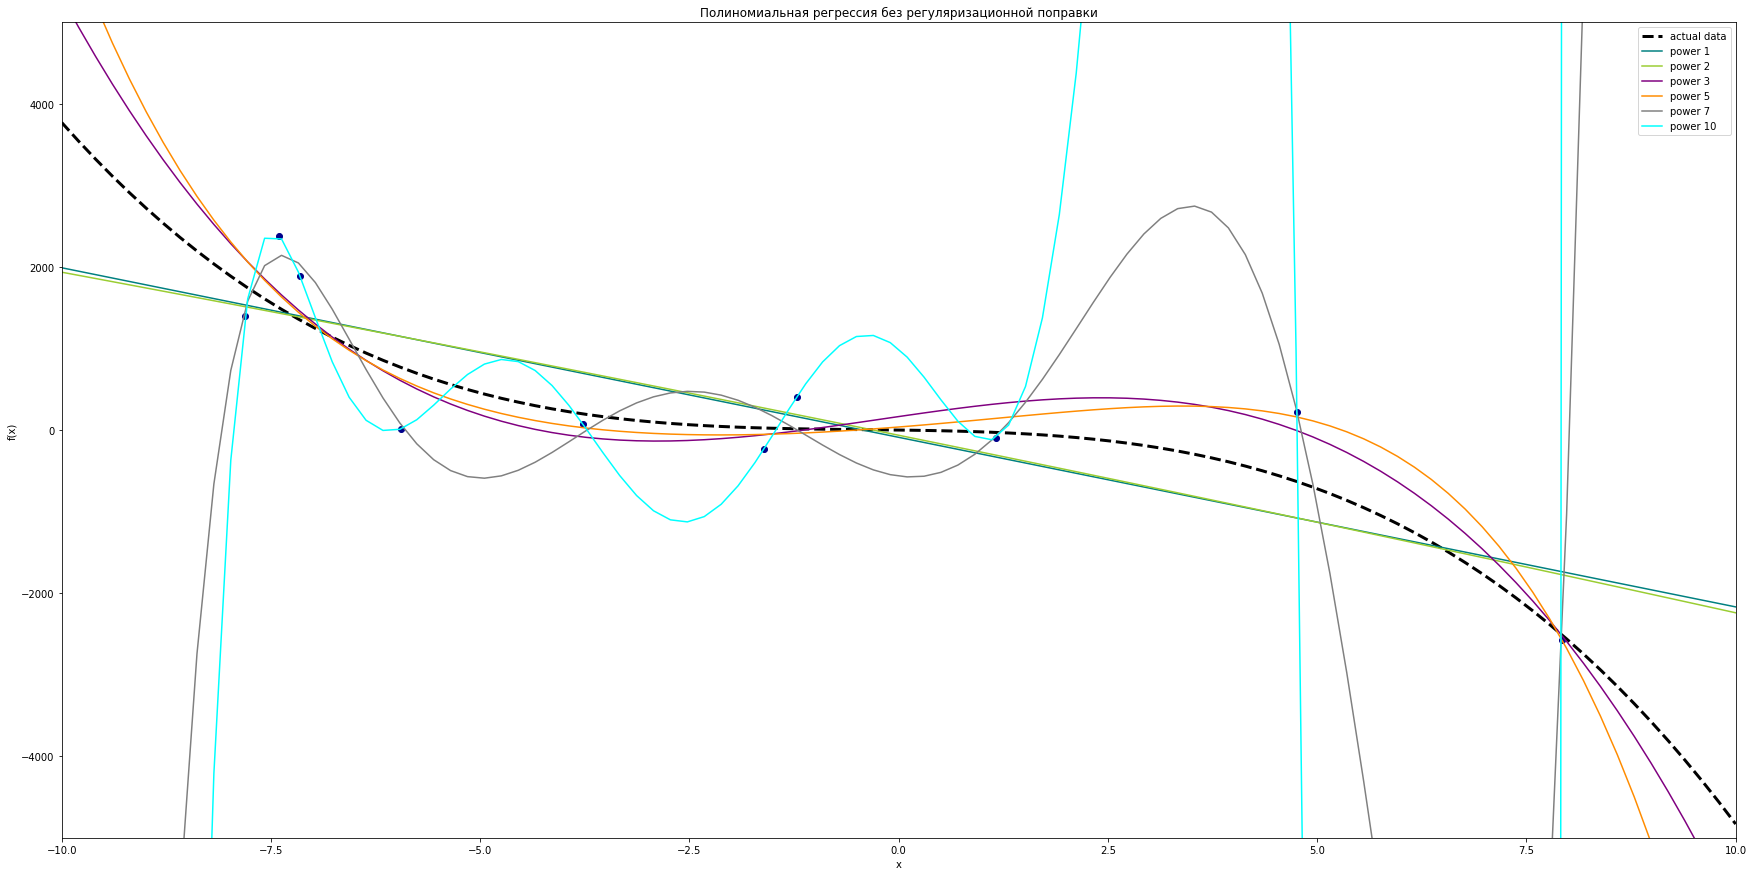

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(30)
ax.set_prop_cycle(color=["black", "teal", "yellowgreen", "purple", "darkorange", "grey", "cyan", "orchid", "blue", "magenta", "tomato"])
ax.plot(x, f(x), linestyle="dashed", linewidth=3, label="actual data")
ax.set(xlabel='x', ylabel='f(x)')
ax.set_title('Полиномиальная регрессия без регуляризационной поправки')
ax.set_ylim(-5000, 5000)
ax.set_xlim(-10,10)
ax.scatter(x_data, f_data, c="darkblue")

for power in [1, 2, 3, 5, 7, 10]:
  model1 = polynomial_regression_lbfgs(power)
  model1.fit(x_data, f_data)
  ax.plot(x, model1.predict(x), label=f'power {power}')
  
ax.legend()
  

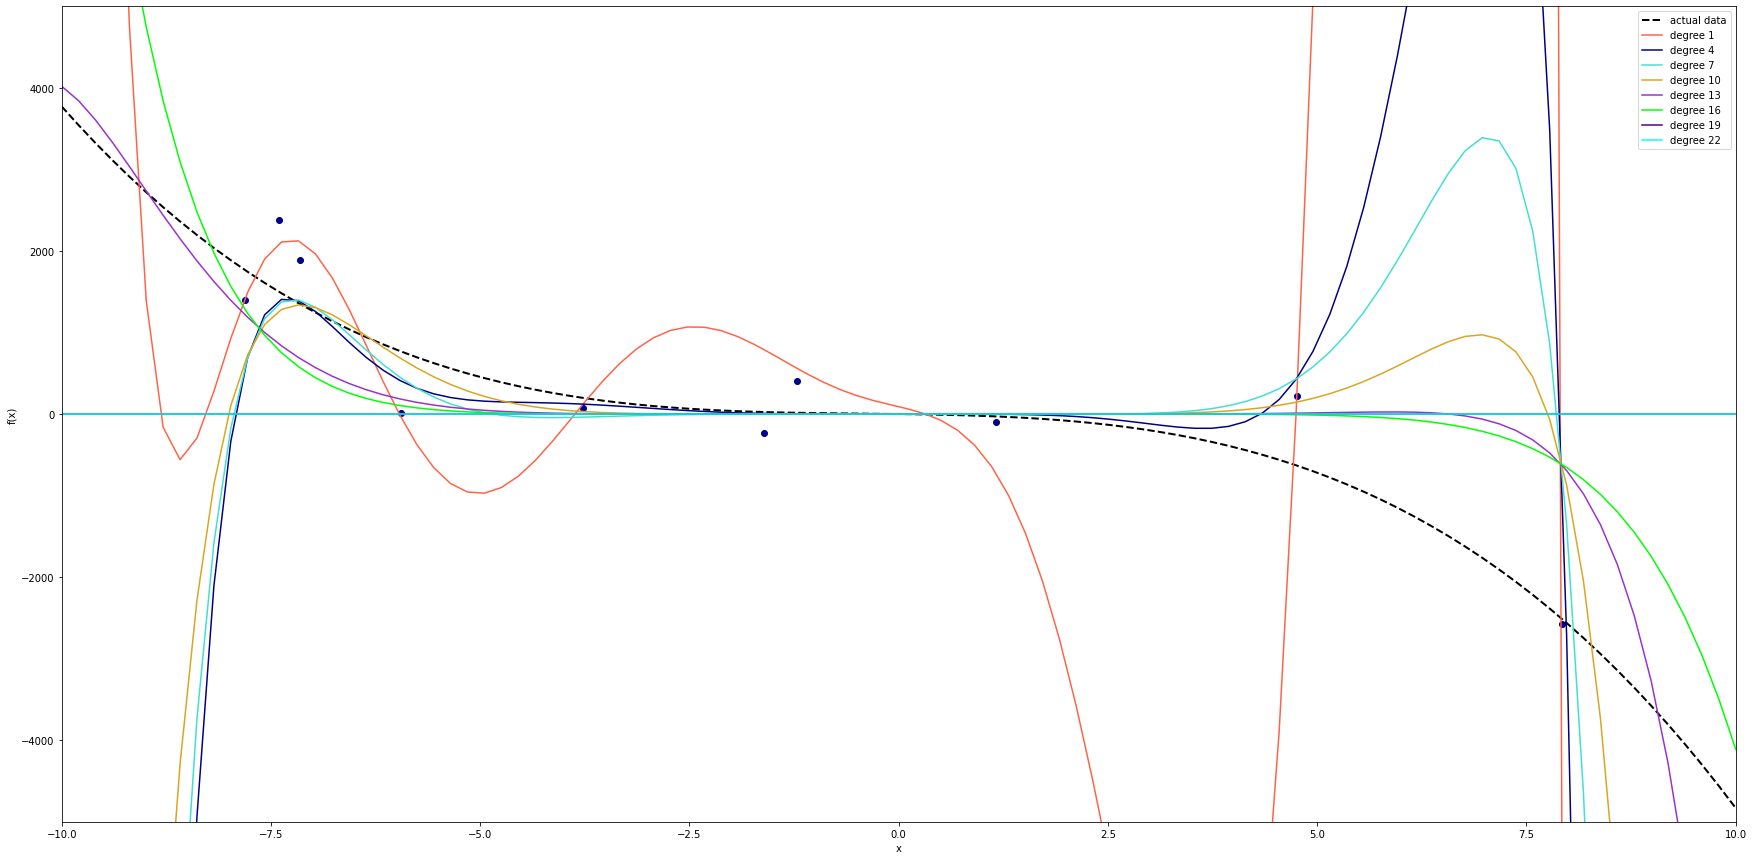

In [ ]:
# Попробуем подобрать коэффициент поправки
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(30)
ax.set_prop_cycle(color=["black", "tomato", "navy", "turquoise", "goldenrod", "darkorchid", "lime", "indigo", "cyan", "violet", "red"])
ax.plot(x, f(x), linestyle="--", linewidth=2, label="actual data")
ax.set(xlabel='x', ylabel='f(x)')
ax.set_ylim(-5000, 5000)
ax.set_xlim(-10,10)
ax.scatter(x_data, f_data, c="darkblue")

for degree in range(1, 23, 3):
  my_model = polynomial_regression_lbfgs_l2_reg(10**degree, 10)
  my_model.fit(x_data, f_data)
  ax.plot(x, my_model.predict(x), label=f'degree {degree}')
  
ax.legend()

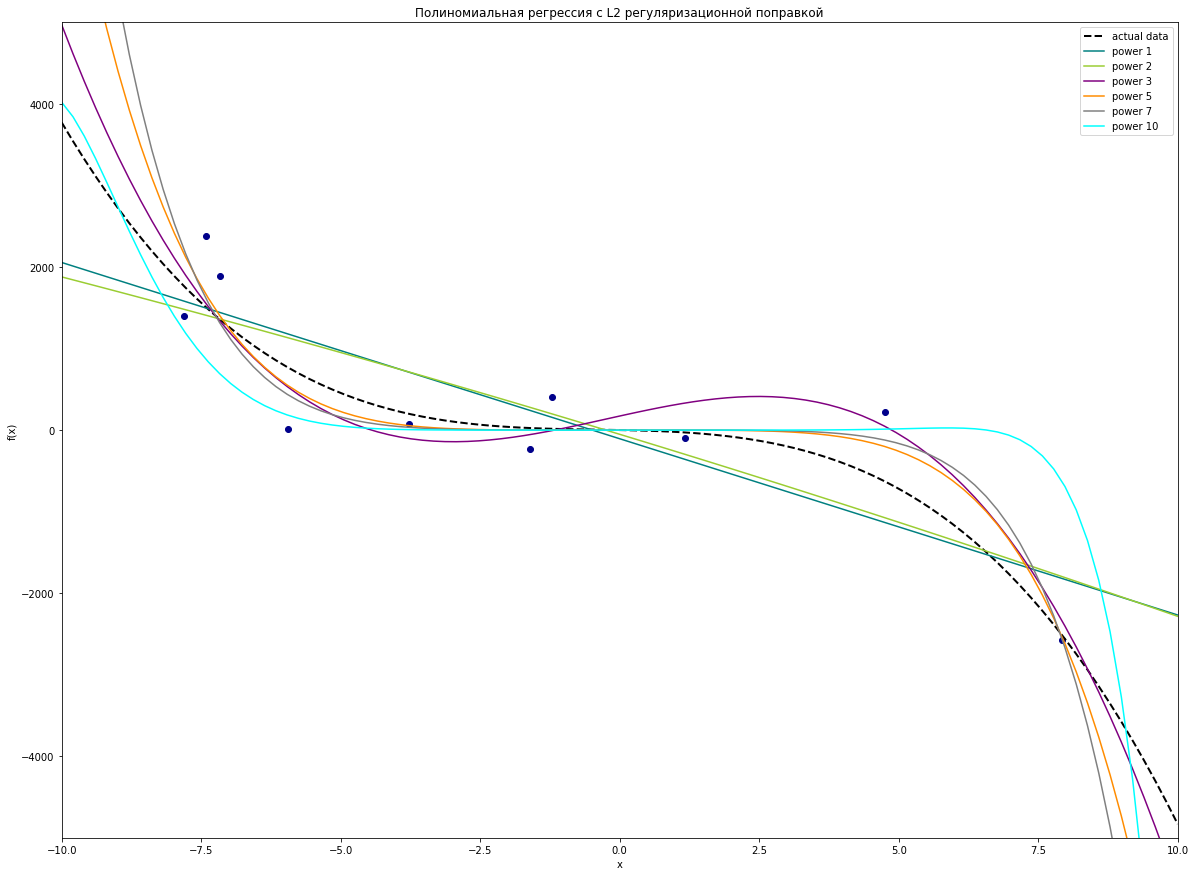

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(20)
ax.set_prop_cycle(color=["black", "teal", "yellowgreen", "purple", "darkorange", "grey", "cyan", "orchid", "blue", "magenta", "tomato"])
ax.plot(x, f(x), linestyle="--", linewidth=2, label="actual data")
ax.set_title('Полиномиальная регрессия с L2 регуляризационной поправкой')
ax.set(xlabel='x', ylabel='f(x)')
ax.set_ylim(-5000, 5000)
ax.set_xlim(-10,10)
ax.scatter(x_data, f_data, c="darkblue")

for power, degree in [(1, 1), (2, 1), (3, 1), (5, 5), (7, 7), (10, 13)]:
  model2 = polynomial_regression_lbfgs_l2_reg(10**degree, power)
  model2.fit(x_data, f_data)
  ax.plot(x, model2.predict(x), label=f'power {power}')
  
ax.legend()
   

In [ ]:
# Для оценки предсказательной способности метода увеличим количество точек
x_data_valid = np.random.uniform(-10, 10, size=(50,))
f_data_valid = [f(i) for i in x_data_valid] + np.random.uniform(-1000, 1000, size=(50,))

In [ ]:
model_skr_1 = polynomial_regression_sklearn_ridge(3)
model_skr_1.fit(x_data, f_data)
model_l2_1 = polynomial_regression_lbfgs_l2_reg(1, 3)
model_l2_1.fit(x_data, f_data)
print(f'Коэффициенты sklearn: {model_skr_1.coef_}, интерцепт: {model_skr_1.intercept_}')
print(f'Коэффициенты полиномиальной регресии: {model_l2_1.w}, интерцепт: {model_l2_1.w0}')


Коэффициенты sklearn: [ -0.14200296 -10.82404134  -4.38063882], интерцепт: 135.69256399878617
Коэффициенты полиномиальной регресии: [[-26.18244814 -11.00311131  -4.04251324]], интерцепт: 151.43698038832488


In [ ]:
def r_square(y, y_real):
  ss_total=np.sum((y_real-np.mean(y_real))**2)
  ss_res=np.sum((y_real-y)**2)
  return 1-ss_res/ss_total


In [ ]:
power3_mod = polynomial_regression_lbfgs_l2_reg(1, 3)
power3_mod.fit(x_data_valid, f_data_valid)
print(r_square(power3_mod.predict(x_data_valid), f_data_valid))
print(r2_score(power3_mod.predict(x_data_valid), f_data_valid))

0.9252891850880393
0.919257125880473


In [ ]:
power5_mod = polynomial_regression_lbfgs_l2_reg(10**5, 5)
power5_mod.fit(x_data_valid, f_data_valid)
print(r_square(power5_mod.predict(x_data_valid), f_data_valid))
print(r2_score(power5_mod.predict(x_data_valid), f_data_valid))

0.9064316484376322
0.8935944529052989


In [ ]:
power7_mod = polynomial_regression_lbfgs_l2_reg(10**7, 7)
power7_mod.fit(x_data_valid, f_data_valid)
print(r_square(power7_mod.predict(x_data_valid), f_data_valid))
print(r2_score(power7_mod.predict(x_data_valid), f_data_valid))

0.8305282024243584
0.7887561004790643


In [ ]:
power10_mod = polynomial_regression_lbfgs_l2_reg(10**(13), 10)
power10_mod.fit(x_data_valid, f_data_valid)
print(r_square(power10_mod.predict(x_data_valid), f_data_valid))
print(r2_score(power10_mod.predict(x_data_valid), f_data_valid))

0.34539101946908535
-3.890881108352752


In [ ]:
indexes=np.arange(len(f_data_valid))%5
y_actual_p3=[]
y_predicted_p3=[]

for i in range(5):
    y_actual_p3.append(f_data_valid[indexes==i])
    power3_mod.fit(x_data_valid[indexes!=i], f_data_valid[indexes!=i])
    y_predicted_p3.append(power3_mod.predict(x_data_valid[indexes==i]))
    
y_actual_p3=np.concatenate(y_actual_p3)
y_predicted_p3=np.concatenate(y_predicted_p3)
print(r_square(y_predicted_p3, y_actual_p3))

0.9029594954791467


In [ ]:
y_actual_p5=[]
y_predicted_p5=[]

for i in range(5):
    y_actual_p5.append(f_data_valid[indexes==i])
    power5_mod.fit(x_data_valid[indexes!=i], f_data_valid[indexes!=i])
    y_predicted_p5.append(power5_mod.predict(x_data_valid[indexes==i]))
    
y_actual_p5=np.concatenate(y_actual_p5)
y_predicted_p5=np.concatenate(y_predicted_p5)
print(r_square(y_predicted_p5, y_actual_p5))

0.9075992422584207


In [ ]:
y_actual_p7=[]
y_predicted_p7=[]

for i in range(5):
    y_actual_p7.append(f_data_valid[indexes==i])
    power7_mod.fit(x_data_valid[indexes!=i], f_data_valid[indexes!=i])
    y_predicted_p7.append(power7_mod.predict(x_data_valid[indexes==i]))
    
y_actual_p7=np.concatenate(y_actual_p7)
y_predicted_p7=np.concatenate(y_predicted_p7)
print(r_square(y_predicted_p7, y_actual_p7))

0.8599280941585534


In [ ]:
y_actual_p10=[]
y_predicted_p10=[]

for i in range(5):
    y_actual_p10.append(f_data_valid[indexes==i])
    power10_mod.fit(x_data_valid[indexes!=i], f_data_valid[indexes!=i])
    y_predicted_p10.append(power10_mod.predict(x_data_valid[indexes==i]))
    
y_actual_p10=np.concatenate(y_actual_p10)
y_predicted_p10=np.concatenate(y_predicted_p10)
print(r_square(y_predicted_p10, y_actual_p10))

0.44375475929304187
